# Summary:
This notebook will cover using pre-trained weights from **BioBERT** to embed abstracts.

# Table of contents
* [1. Embedding using BioBERT](#Part1_link)
<br >&nbsp;&nbsp;&nbsp;[1.1 Load pre-trained BioBERT](#Part1.1_link)
<br >&nbsp;&nbsp;&nbsp;[1.2 Embed abstracts and titles](#Part1.2_link)
* [2. Evaluate embedding vectors from BioBERT](#Part2_link)
* [3. Compare BioBERT, LDA and Word2Vec models](#Part3_link)
* [4. Visualize BioBERT embedding result](#Part4_link)
<br >&nbsp;&nbsp;&nbsp;[4.1 Visualize clustering by cancer type](#Part4.1_link)
<br >&nbsp;&nbsp;&nbsp;[4.2 Visualize clustering by gene](#Part4.2_link)

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from collections import defaultdict
import time

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import gensim
from keras.preprocessing import text
from keras.preprocessing import sequence
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import itertools
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import io
import json
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F

from transformers import BertTokenizer
from transformers import BertModel
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import math

Using TensorFlow backend.


**Reference**:
<br>https://github.com/dmis-lab/biobert
<br>https://mccormickml.com/2019/07/22/BERT-fine-tuning/
<BR>https://academic.oup.com/bioinformatics/advance-article/doi/10.1093/bioinformatics/btz682/5566506

In [3]:
base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'
abstract_df=pd.read_csv(os.path.join(base_dir, "data/abstract_citation_annot_df_50930.csv"),index_col='pmid')
cancertype_flattened_df=pickle.load(open(os.path.join(base_dir, "data/cancertype_df2.pkl"),"rb"))

In [4]:
abstract_df['pmid']=abstract_df.index

In [4]:
print('unique pmid with cancer types: {}'.format(cancertype_flattened_df.pmid.nunique()))
print('unique cancer types: {}'.format(cancertype_flattened_df.cancer_type.nunique()))

unique pmid with cancer types: 42455
unique cancer types: 55


In [5]:
cancer_types=np.array(cancertype_flattened_df.cancer_type.value_counts().index)
print(len(cancer_types))

55


<a id='Part1_link'></a>
# 1. Embedding using BioBERT

<a id='Part1.1_link'></a>
## 1.1 Load pre-trained BioBERT

In [6]:
model = BertModel.from_pretrained('/Users/yuchenxie/Documents/Insight/OncoMatch/bert/biobert_v1.1_pubmed')

In [10]:
tokenizer = BertTokenizer.from_pretrained('/Users/yuchenxie/Documents/Insight/OncoMatch/bert/biobert_v1.1_pubmed', do_lower_case=True)

<a id='Part1.2_link'></a>
## 1.2 Embed abstracts and titles

In [13]:
def prepare_input_seq(input_seq, tokenizer, max_len):
    # here prepare the input sequence for the Bert model
    tokens0 = tokenizer.tokenize(input_seq)
    for j,t in enumerate(tokens0):
        if t in [".","?","!"]:
            tokens0[j] = t+" [SEP]"
    tokens = []
    for t in tokens0:
        tokens+=t.split()
    if tokens[-1]!='[SEP]':
        tokens = ['[CLS]'] + tokens + ['[SEP]']
    else:
        tokens = ['[CLS]'] + tokens

    if len(tokens)>max_len:
        #padded_tokens=tokens +['[PAD]' for _ in range(max_len-len(tokens))]
    #else:
        padded_tokens = tokens[:max_len]
    else:
        padded_tokens = tokens

    #attn_mask=[1 if token != '[PAD]' else 0 for token in padded_tokens]

    #segment_ids = []
    
    indexed_tokens = tokenizer.convert_tokens_to_ids(padded_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])
    #segments_tensors = torch.tensor([segment_ids])
    #attn_mask = torch.tensor([attn_mask])

    return tokens_tensor

In [14]:
def embed_sents(sents,model,max_len):
    # LM is the language model to be loaded separately.
    id2sent = {j:sent for j,sent in enumerate(sents)}
    emb_mat = np.zeros([len(id2sent),768])
    for j,sent in enumerate(sents):
        input_seq = sent
        tokens_tensor = prepare_input_seq(input_seq,tokenizer,max_len)
        val, hidden = model(tokens_tensor)
        #print('val')
        #print(val.shape)
        #print('hidden')
        #print(hidden.shape)
        val = torch.squeeze(val).mean(axis=0).reshape(1,-1)
        #print(val)
        emb_mat[j,:] = val.detach().numpy()
        
    return emb_mat

In [ ]:
abstract_mat = embed_sents(abstract_df.abstract.values.tolist(), model,max_len=128)
title_mat = embed_sents(abstract_df.article_title.values.tolist(), model,max_len=128)

In [ ]:
abstract_mebed_df=pd.DataFrame(abstract_mat,index=abstract_df.index)
title_mebed_df=pd.DataFrame(title_mat,index=abstract_df.index)

<a id='Part2_link'></a>
# 2. Evaluate embedding vectors from BioBERT

### Rank similarity scores in each cancer_type

In [175]:
cancer_types=np.array(cancertype_flattened_df.cancer_type.value_counts().index)
cancer2pmid_dict=pickle.load(open(os.path.join(base_dir, "data/cancer2pmid_dict.pkl"),"rb"))

In [182]:
abstract_embedded_df = pd.read_csv(os.path.join(base_dir, 'bert_data/abstract_embed_bert_maxlen128.csv'),index_col='pmid')
title_embedded_df = pd.read_csv(os.path.join(base_dir, 'bert_data/title_embed_bert_maxlen128.csv'),index_col='pmid')

In [202]:
def bert_title_rank(pmid):
    title_query = title_embedded_df.loc[pmid].values.reshape(1,-1)
    similarity_score = cosine_similarity(X=subset_abstract_embedded_df,Y=title_query,dense_output=False)
    similarity_df=pd.DataFrame({'pmid':subset_abstract_embedded_df.index, 'bert_score':similarity_score.squeeze()}).sort_values(by=['bert_score'],ascending=False).reset_index().drop(['index'],axis=1)
    return int(similarity_df.index[similarity_df.pmid==pmid].values)

In [212]:
for cancer_type in cancer_types:
    prefix="_".join(i.lower() for i in cancer_type.split())
    pmid_list = cancer2pmid_dict[cancer_type]
    subset_df=abstract_df.loc[pmid_list]
    subset_abstract_embedded_df=abstract_embedded_df.loc[subset_df.index]
    subset_df['bert_similarity_rank_{}'.format(prefix)] = subset_df.apply(lambda x:bert_title_rank(x.pmid),axis=1)
    subset_df['bert_similarity_rank_{}_percentile'.format(prefix)] = subset_df['bert_similarity_rank_{}'.format(prefix)]/subset_df.shape[0]
    subset_df.to_csv(os.path.join(base_dir, 'bert_data/{}_bert_maxlen128_similarity_score.csv'.format(prefix)), index=False)

Breast Cancer
subset_df: (8563, 10)
Lung Cancer
subset_df: (5518, 10)
Leukemia
subset_df: (4962, 10)
Prostate Cancer
subset_df: (4018, 10)
Colorectal Cancer
subset_df: (3611, 10)
Lymphoma
subset_df: (3003, 10)
Bone Cancer
subset_df: (2859, 10)
Melanoma
subset_df: (2742, 10)
Liver Cancer
subset_df: (2584, 10)
Kidney Cancer
subset_df: (2315, 10)
Ovarian Cancer
subset_df: (2363, 10)
Pancreatic Cancer
subset_df: (2132, 10)
Brain Tumor
subset_df: (3103, 10)
Head and Neck Cancer
subset_df: (1996, 10)
Acute Myeloid Leukemia (AML)
subset_df: (1499, 10)
Multiple Myeloma
subset_df: (1425, 10)
Sarcoma
subset_df: (1477, 10)
Bladder Cancer
subset_df: (1151, 10)
Skin Cancer
subset_df: (1124, 10)
Gastric Cancer
subset_df: (1064, 10)
Gastrointestinal Tumor
subset_df: (989, 10)
Endometrial Cancer
subset_df: (1053, 10)
Acute Lymphoblastic Leukemia (ALL)
subset_df: (915, 10)
Chronic Lymphocytic Leukemia (CLL)
subset_df: (803, 10)
Cardiac Tumors
subset_df: (862, 10)
Cervical Cancer
subset_df: (884, 10)
Es

In [215]:
def plot_bert_similarity_rank(cancer_type):
    prefix="_".join(i.lower() for i in cancer_type.split())
    subset_df = pd.read_csv(os.path.join(base_dir, 'bert_data/{}_bert_maxlen128_similarity_score.csv'.format(prefix)))
    subset_df['bert_similarity_rank_{}_percentile'.format(prefix)] = subset_df['bert_similarity_rank_{}'.format(prefix)]/subset_df.shape[0]
    
    fig,ax=plt.subplots(1,1,figsize=(12,6))
    sns.distplot(subset_df['bert_similarity_rank_{}_percentile'.format(prefix)], hist=True,kde=False,bins=int(subset_df.shape[0]/50) if subset_df.shape[0]>1000 else 20,ax=ax,hist_kws={'edgecolor':'black'})
    ax.set_xlim(0,1)
    ax.set_xlabel('bert_similarity_score_rank_percentile_{}'.format(prefix), fontsize=12)
    ax.set_yticks([])
    ax.set_title('Distribution of bert similarity score rank for {}'.format(cancer_type), fontsize=18)
    plt.show()
    fig.savefig(os.path.join(base_dir, 'bert_data/{}_bert_maxlen128_similarity_score.png'.format(prefix)))

In [ ]:
for cancer_type in cancer_types:
    plot_bert_similarity_rank(cancer_type)

<a id='Part3_link'></a>
# 3. Compare BioBERT, LDA and Word2Vec models

In [17]:
cancer_type = "Breast Cancer"
prefix="_".join(i.lower() for i in cancer_type.split())
subset_w2v_df = pd.read_csv(os.path.join(base_dir, 'models_w2v/{}_w2v_similarity_score.csv'.format(prefix)))
subset_w2v_df['w2v_similarity_rank_{}_percentile'.format(prefix)] = subset_w2v_df['w2v_similarity_rank_{}'.format(prefix)]/subset_w2v_df.shape[0]
subset_lda_df = pd.read_csv(os.path.join(base_dir, 'models_lda/{}_lda_similarity_score.csv'.format(prefix)))
subset_bert_df = pd.read_csv(os.path.join(base_dir, 'bert_data/{}_bert_maxlen128_similarity_score.csv'.format(prefix)))
subset_bert_df['bert_similarity_rank_{}_percentile'.format(prefix)] = subset_bert_df['bert_similarity_rank_{}'.format(prefix)]/subset_bert_df.shape[0]

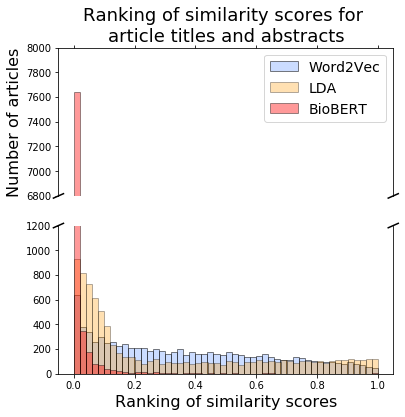

In [18]:
from scipy.stats import norm
fig,(ax1,ax2)=plt.subplots(2,1,sharex=True,figsize=(6,6))
#palette=['blue','orange','red','grey']
palette=['#99bbff','#ff9900','#ff9999','#cc99ff','#59b300']
#sns.distplot(abstract_df['similarity_rank_percentile'],color=palette[2],kde=True,hist=False,ax=ax,label='Word2Vec_PanCancer')
sns.distplot(subset_w2v_df['w2v_similarity_rank_{}_percentile'.format(prefix)],kde=False,hist=True,label='Word2Vec',bins=50, ax=ax1,hist_kws={"histtype": "bar", "color":palette[0],'alpha':0.5,'edgecolor':'black'})
sns.distplot(subset_lda_df['lda_similarity_rank_{}_percentile'.format(prefix)],kde=False,hist=True,label='LDA',bins=50, ax=ax1,hist_kws={"histtype": "bar", "color":palette[1],'alpha':0.3,'edgecolor':'black'})  
sns.distplot(subset_bert_df['bert_similarity_rank_{}_percentile'.format(prefix)],kde=False,hist=True,label='BioBERT',bins=50, ax=ax1,hist_kws={"histtype": "bar", "color":'red','edgecolor':'black'})
sns.distplot(subset_w2v_df['w2v_similarity_rank_{}_percentile'.format(prefix)],kde=False,hist=True,label='Word2Vec',bins=50, ax=ax2,hist_kws={"histtype": "bar", "color":palette[0],'alpha':0.5,'edgecolor':'black'})
sns.distplot(subset_lda_df['lda_similarity_rank_{}_percentile'.format(prefix)],kde=False,hist=True,label='LDA',bins=50, ax=ax2,hist_kws={"histtype": "bar", "color":palette[1],'alpha':0.3,'edgecolor':'black'})  
sns.distplot(subset_bert_df['bert_similarity_rank_{}_percentile'.format(prefix)],kde=False,hist=True,label='BioBERT',bins=50, ax=ax2,hist_kws={"histtype": "bar", "color":'red','edgecolor':'black'})

#ax.set_xlim(0,1)
ax1.set_title('Ranking of similarity scores for \narticle titles and abstracts',fontsize=18)
ax1.set_xlabel("")
ax2.set_xlabel('Ranking of similarity scores', fontsize=16)
ax2.set_ylim(0,1200)
ax1.set_ylim(6800,8000)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
#ax.set_yticks([])
ax1.set_ylabel('Number of articles',fontsize=16)

d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax1.legend(fontsize=14)

**Conclusion**: Overall, BioBERT performs better than LDA and Word2Vec models in matching article abstract to article titles.

<a id='Part4_link'></a>
# 4. Visualize BioBERT embedding result

TSNE plot is good at visualizing high-dimensional data.

In [ ]:
tsne = TSNE()
abstract_tsne = tsne.fit_transform(abstract_embed)
abstract_tsne=pd.DataFrame({'tsne1':abstract_tsne[:,0],'tsne2':abstract_tsne[:,1], 'pmid':abstract_tsne.index})

In [6]:
# abstract_tsne=pd.read_csv(os.path.join(base_dir, 'bert_data/maxlen128/abstract_embed_bert_maxlen128_tsne.csv'))

<a id='Part4.1_link'></a>
## 4.1 Visualize clustering by cancer type

In [7]:
cancer2pmid_dict=pickle.load(open(os.path.join(base_dir, "data/cancer2pmid_dict.pkl"),"rb"))

In [ ]:
for cancer_type in cancer_types[:29]:
    print(cancer_type)
    pmid_array = cancer2pmid_dict[cancer_type]
    abstract_tsne['cancer_type']=abstract_tsne.pmid.apply(lambda x:cancer_type if x in pmid_array else 'NA')
    abstract_tsne0=abstract_tsne[abstract_tsne.cancer_type=='NA']
    abstract_tsne1=abstract_tsne[abstract_tsne.cancer_type==cancer_type]
    abstract_tsne2=pd.concat([abstract_tsne0, abstract_tsne1])
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.scatterplot(x='tsne1',y='tsne2',data=abstract_tsne2, hue = 'cancer_type', hue_order=[cancer_type,'NA'], palette=['red','blue'], ax=ax, alpha=1,s=10)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('{}_tsne_plot'.format(cancer_type), fontsize=20)
    plt.show()
    #fig.savefig(os.path.join(base_dir, 'bert_data/maxlen128/bert_maxlen128_{}_tsne.png'.format(cancer_type)))

In [9]:
breast_pmid = cancer2pmid_dict['Breast Cancer']
lung_pmid = cancer2pmid_dict['Lung Cancer']
leukemia_pmid = cancer2pmid_dict['Leukemia']
prostate_pmid = cancer2pmid_dict['Prostate Cancer']
colorectal_pmid = cancer2pmid_dict['Colorectal Cancer']

In [10]:
breast_pmid1 = np.array([i for i in breast_pmid if i not in lung_pmid and i not in leukemia_pmid and i not in prostate_pmid and i not in colorectal_pmid])
lung_pmid1 = np.array([i for i in lung_pmid if i not in breast_pmid and i not in leukemia_pmid and i not in prostate_pmid and i not in colorectal_pmid])
leukemia_pmid1 = np.array([i for i in leukemia_pmid if i not in breast_pmid and i not in lung_pmid and i not in prostate_pmid and i not in colorectal_pmid])
prostate_pmid1 = np.array([i for i in prostate_pmid if i not in breast_pmid and i not in lung_pmid and i not in leukemia_pmid and i not in colorectal_pmid])
colorectal_pmid1 = np.array([i for i in colorectal_pmid if i not in breast_pmid and i not in lung_pmid and i not in leukemia_pmid and i not in prostate_pmid])

In [31]:
abstract_tsne['cancer_type']=abstract_tsne.pmid.apply(lambda x:'Breast Cancer' if x in breast_pmid1 else ('Lung Cancer' if x in lung_pmid1 else ('Leukemia' if x in leukemia_pmid1 else ('Prostate Cancer' if x in prostate_pmid1 else ('Colorectal Cancer' if x in colorectal_pmid1 else 'NA')))))
abstract_tsne['cancer_type2']=abstract_tsne.cancer_type.apply(lambda x:1 if x!='NA' else 0)
abstract_tsne0 = abstract_tsne[abstract_tsne.cancer_type2 == 0]
abstract_tsne1 = abstract_tsne[abstract_tsne.cancer_type2 == 1]
abstract_tsne2 = pd.concat([abstract_tsne0, abstract_tsne1])

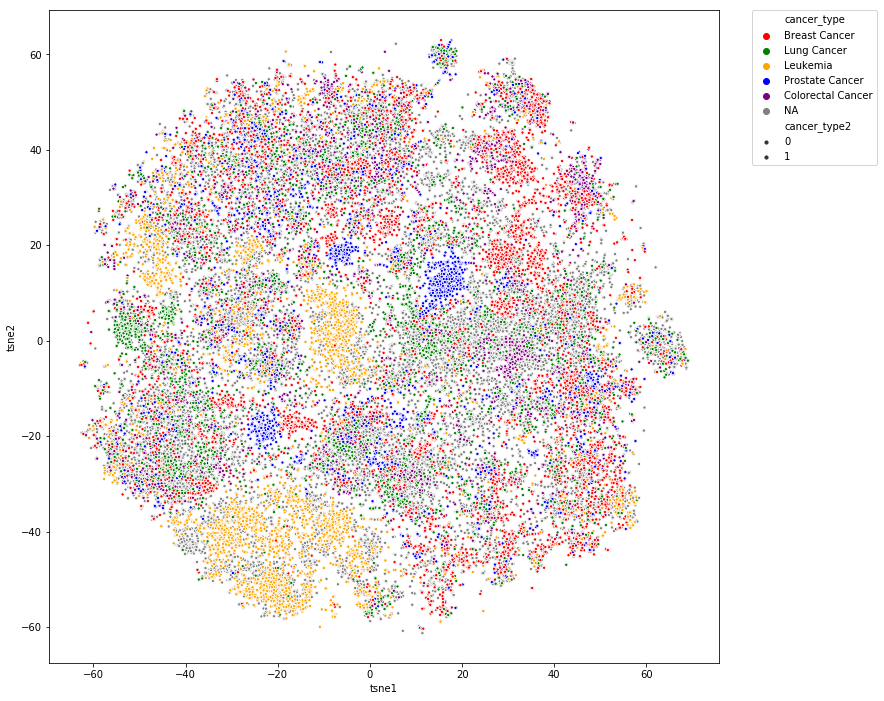

In [35]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='tsne1',
                y='tsne2',
                data=abstract_tsne2, 
                hue = 'cancer_type', 
                hue_order=['Breast Cancer','Lung Cancer','Leukemia','Prostate Cancer','Colorectal Cancer','NA'], 
                palette=['red','green','orange','blue','purple','grey'], 
                ax=ax, 
                alpha=1,
                size='cancer_type2',
                sizes=(10,10))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<a id='Part4.2_link'></a>
## 4.2 Visualize clustering by gene

In [9]:
HGNC_flattened_df=pd.read_csv(os.path.join(base_dir, "data/HGNC_df2.csv"))

In [ ]:
for HGNC in HGNC_flattened_df.HGNC.unique():
    pmid_array = HGNC_flattened_df[HGNC_flattened_df.HGNC==HGNC].pmid.values
    abstract_tsne['gene']=abstract_tsne.pmid.apply(lambda x:HGNC if x in pmid_array else 'NA')
    abstract_tsne0=abstract_tsne[abstract_tsne.gene=='NA']
    abstract_tsne1=abstract_tsne[abstract_tsne.gene==HGNC]
    abstract_tsne2=pd.concat([abstract_tsne0, abstract_tsne1])
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.scatterplot(x='tsne1',y='tsne2',data=abstract_tsne2, hue = 'gene', hue_order=[HGNC,'NA'], palette=['red','blue'], ax=ax, alpha=1,s=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('{}_tsne_plot'.format(HGNC), fontsize=20)
    plt.show()
    if HGNC =='BRCA1/2':
        HGNC='BRCA'
    fig.savefig(os.path.join(base_dir, 'bert_data/maxlen128/bert_maxlen128_{}_tsne.png'.format(HGNC)))